In [23]:
import pickle
import numpy as np

def load_cifar_batch(batch_path):
    with open(batch_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        X = batch[b'data']
        y = np.array(batch[b'labels'])
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return X, y


# ----------------------------
# PATHS
# ----------------------------
train_batch_path = "cifar-10-python/cifar-10-batches-py/data_batch_1"
test_batch_path  = "cifar-10-python/cifar-10-batches-py/test_batch"

# ----------------------------
# LOAD DATA
# ----------------------------
X_train, y_train = load_cifar_batch(train_batch_path)
X_test, y_test   = load_cifar_batch(test_batch_path)

# ----------------------------
# TAKE ONLY 2000 SAMPLES
# ----------------------------
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test= X_test[:100]
y_test=y_test[:100]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (5000, 32, 32, 3) (5000,)
Test : (100, 32, 32, 3) (100,)


In [24]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [25]:
y_train = y_train.reshape(-1)
y_test  = y_test.reshape(-1)

In [26]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
import numpy as np

# 🔹 Preprocessing per metric
# ==============================================

# 1️⃣ Euclidean, Manhattan, Minkowski → Min–Max Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️⃣ Cosine → Row normalization (L2)
normalizer = Normalizer(norm='l2')
X_train_cos = normalizer.fit_transform(X_train)
X_test_cos = normalizer.transform(X_test)

# 3️⃣ Hamming → Binarize by median threshold
median_vals = np.median(X_train, axis=0)

X_train_ham = (X_train > median_vals).astype(np.uint8)
X_test_ham  = (X_test > median_vals).astype(np.uint8)



🔍 Finding best k for each distance metric...

Distance Metric: EUCLIDEAN
  k= 3 -> Test Accuracy = 0.3100
  k= 4 -> Test Accuracy = 0.3500
  k= 9 -> Test Accuracy = 0.3500
  k=20 -> Test Accuracy = 0.3000
  k=47 -> Test Accuracy = 0.2800
✅ Best k for EUCLIDEAN: 4 (Accuracy = 0.3500)

Distance Metric: MANHATTAN
  k= 3 -> Test Accuracy = 0.2600
  k= 4 -> Test Accuracy = 0.2800
  k= 9 -> Test Accuracy = 0.3200
  k=20 -> Test Accuracy = 0.3300
  k=47 -> Test Accuracy = 0.2900
✅ Best k for MANHATTAN: 20 (Accuracy = 0.3300)

Distance Metric: MINKOWSKI
  k= 3 -> Test Accuracy = 0.2700
  k= 4 -> Test Accuracy = 0.3000
  k= 9 -> Test Accuracy = 0.3300
  k=20 -> Test Accuracy = 0.2600
  k=47 -> Test Accuracy = 0.2700
✅ Best k for MINKOWSKI: 9 (Accuracy = 0.3300)

Distance Metric: COSINE
  k= 3 -> Test Accuracy = 0.2700
  k= 4 -> Test Accuracy = 0.2600
  k= 9 -> Test Accuracy = 0.2700
  k=20 -> Test Accuracy = 0.2600
  k=47 -> Test Accuracy = 0.2900
✅ Best k for COSINE: 47 (Accuracy = 0.2900)

D

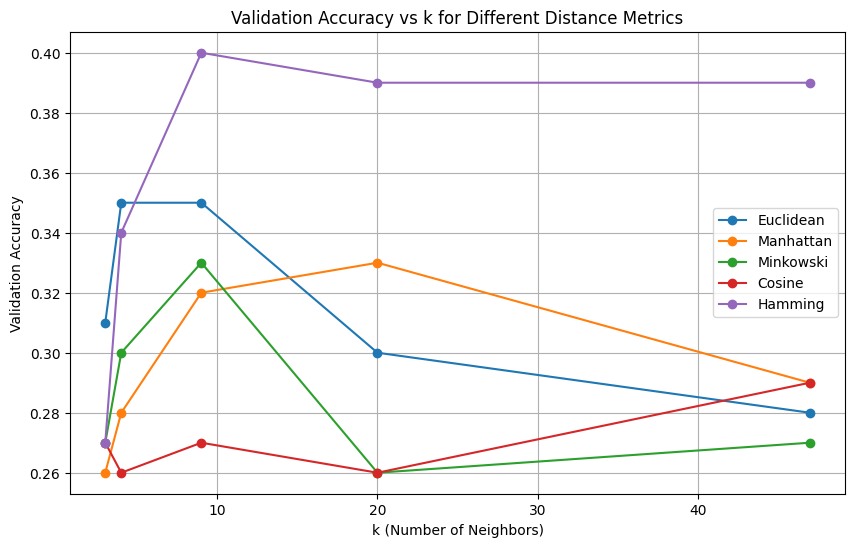


📊 Summary of Best k for Each Distance Metric:
--------------------------------------------------
Euclidean    | Best k =  4 | Accuracy = 0.3500
Manhattan    | Best k = 20 | Accuracy = 0.3300
Minkowski    | Best k =  9 | Accuracy = 0.3300
Cosine       | Best k = 47 | Accuracy = 0.2900
Hamming      | Best k =  9 | Accuracy = 0.4000


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# -------------------------
# Distance functions (pairwise)
# -------------------------
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def minkowski_distance(x1, x2, p=3):
    return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

def cosine_distance(x1, x2, eps=1e-10):
    dot = np.dot(x1, x2)
    n1 = np.linalg.norm(x1)
    n2 = np.linalg.norm(x2)
    if n1 < eps or n2 < eps:
        return 1.0
    return 1 - (dot / (n1 * n2))

def hamming_distance(x1, x2):
    # expects binary vectors (0/1)
    return np.mean(x1 != x2)

# -------------------------
# Simple KNN (your loop-based version)
# -------------------------
class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean', p=3):
        self.k = k
        self.distance_metric = distance_metric
        self.p = p

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _compute_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return euclidean_distance(x1, x2)
        elif self.distance_metric == 'manhattan':
            return manhattan_distance(x1, x2)
        elif self.distance_metric == 'minkowski':
            return minkowski_distance(x1, x2, p=self.p)
        elif self.distance_metric == 'cosine':
            return cosine_distance(x1, x2)
        elif self.distance_metric == 'hamming':
            return hamming_distance(x1, x2)
        else:
            raise ValueError("Unknown distance metric")

    def _predict_single_point(self, test_point):
        distances = []
        for i, train_point in enumerate(self.X_train):
            dist = self._compute_distance(test_point, train_point)
            distances.append((dist, self.y_train[i]))

        # Sort by distance and get the k nearest neighbors
        distances.sort(key=lambda x: x[0])
        k_nearest_neighbors = distances[:self.k]

        # Extract the labels of the k nearest neighbors
        k_nearest_labels = [label for _, label in k_nearest_neighbors]

        # Perform majority voting
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        return most_common_label

    def predict(self, X_test):
        predictions = [self._predict_single_point(test_point) for test_point in X_test]
        return np.array(predictions)



# Map each metric to the corresponding train/val/test data
metric_to_data = {
    'euclidean': (X_train_scaled,  X_test_scaled),
    'manhattan': (X_train_scaled, X_test_scaled),
    'minkowski': (X_train_scaled,  X_test_scaled),
    'cosine':    (X_train_cos,   X_test_cos),
    'hamming':   (X_train_ham,    X_test_ham)
}

# -------------------------
# Grid search over k and metrics using validation set
# -------------------------
# Define all distance metrics you want to compare
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

# Range of k values to test
#k_values = list(range(1, 50))  # k = 1 to 30
k_values = [3, 4, 9, 20, 47]

# Dictionary to store results
results = {}

print("\n🔍 Finding best k for each distance metric...\n")

# Loop through each metric
for metric in distance_metrics:
    Xtr, Xte = metric_to_data[metric]
    test_accuracies = []

    print(f"Distance Metric: {metric.upper()}")
    for k in k_values:
        clf = KNNClassifier(k=k, distance_metric=metric)
        clf.fit(Xtr, y_train)
        y_pred = clf.predict(Xte)
        acc = accuracy_score(y_test, y_pred)
        test_accuracies.append(acc)
        print(f"  k={k:2d} -> Test Accuracy = {acc:.4f}")

    # Save results for this metric
    results[metric] = test_accuracies

    # Find best k for this metric
    best_k_index = np.argmax(test_accuracies)
    best_k_value = k_values[best_k_index]
    best_acc = test_accuracies[best_k_index]
    print(f"✅ Best k for {metric.upper()}: {best_k_value} (Accuracy = {best_acc:.4f})\n")

# --------------------------------------------------------
# Plot all curves together for comparison
# --------------------------------------------------------
plt.figure(figsize=(10,6))

for metric, accuracies in results.items():
    plt.plot(k_values, accuracies, marker='o', label=f"{metric.capitalize()}")

plt.title("Validation Accuracy vs k for Different Distance Metrics")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------
# Display best k for each metric in a summary table
# --------------------------------------------------------
print("\n📊 Summary of Best k for Each Distance Metric:")
print("-" * 50)
for metric, accuracies in results.items():
    best_k = k_values[np.argmax(accuracies)]
    best_acc = np.max(accuracies)
    print(f"{metric.capitalize():<12} | Best k = {best_k:2d} | Accuracy = {best_acc:.4f}")



<Figure size 1000x800 with 0 Axes>

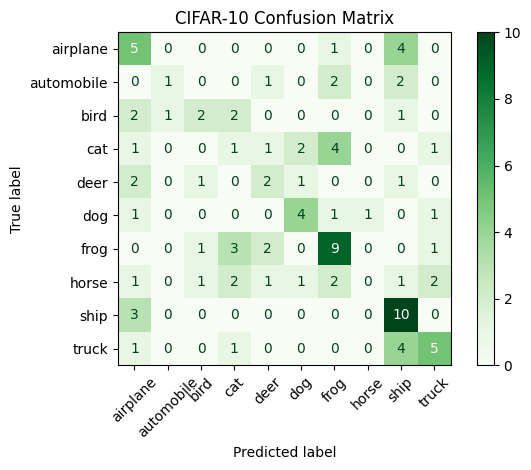


Classification Report (CIFAR-10):

              precision    recall  f1-score   support

    airplane     0.3125    0.5000    0.3846        10
  automobile     0.5000    0.1667    0.2500         6
        bird     0.4000    0.2500    0.3077         8
         cat     0.1111    0.1000    0.1053        10
        deer     0.2857    0.2857    0.2857         7
         dog     0.5000    0.5000    0.5000         8
        frog     0.4737    0.5625    0.5143        16
       horse     0.0000    0.0000    0.0000        11
        ship     0.4348    0.7692    0.5556        13
       truck     0.5000    0.4545    0.4762        11

    accuracy                         0.3900       100
   macro avg     0.3518    0.3589    0.3379       100
weighted avg     0.3517    0.3900    0.3555       100



In [34]:
# -------------------------
# Confusion Matrix & Classification Report (CIFAR-10)
# -------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ------------------------------------------------
# Example: y_test and y_pred must already be ready
# y_test = true labels  (shape: N)
# y_pred = predicted labels (shape: N)
# ------------------------------------------------

# CIFAR-10 class names (optional but useful)
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)
disp.plot(include_values=True, cmap='Greens', xticks_rotation=45)
plt.title("CIFAR-10 Confusion Matrix")
plt.tight_layout()
plt.show()

# -------------------------
# Classification Report
# -------------------------
print("\nClassification Report (CIFAR-10):\n")
print(classification_report(y_test, y_pred, target_names=cifar10_labels, digits=4))


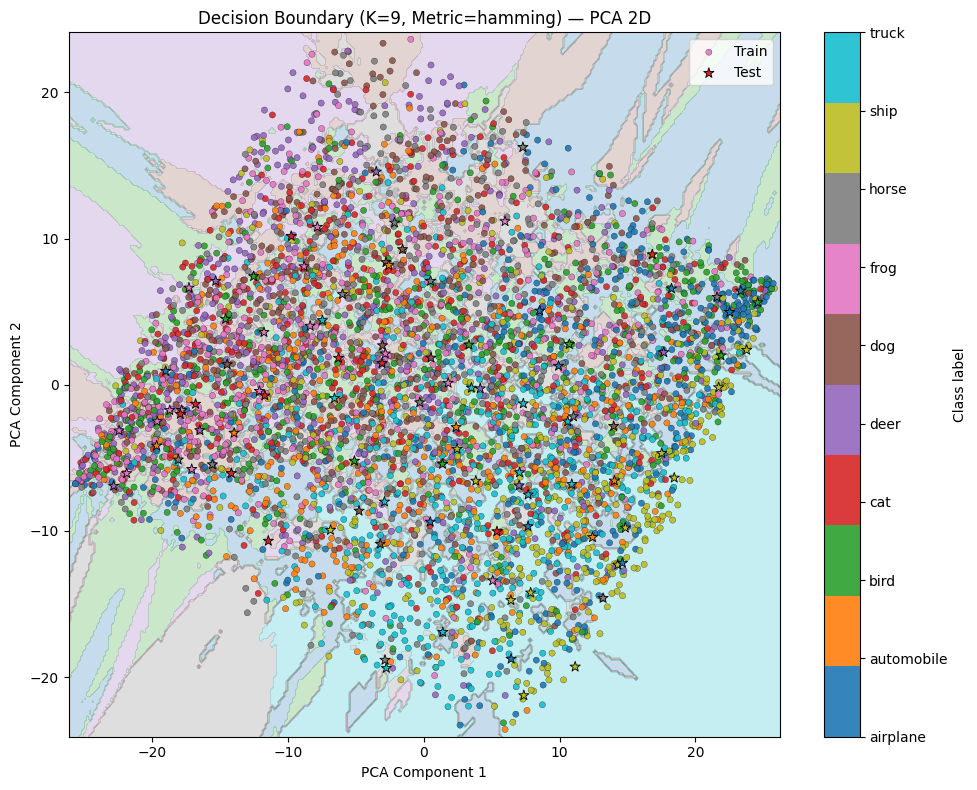

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

# CIFAR-10 class names (optional)
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# ----------------------------
# Pick best model (set these)
# ----------------------------
best_metric = "hamming"   # replace with your best metric
best_k = 9                  # replace with your best k

# ----------------------------
# Prepare 2D data using PCA
# ----------------------------
# metric_to_data should map metric -> (X_train_metric, X_test_metric)
Xtr_best, Xte_best = metric_to_data[best_metric]   # <-- two elements

# y_train and y_test must correspond to Xtr_best and Xte_best respectively
# (i.e. same indices/subsampling used earlier)
# Combine for PCA so projection is shared between train and test
X_combined = np.vstack((Xtr_best, Xte_best))
y_combined = np.hstack((y_train, y_test))

# Reduce to 2D with PCA
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_combined)

# Split back
X_train_2d = X_2d[:len(Xtr_best)]
X_test_2d  = X_2d[len(Xtr_best):]

# ----------------------------
# Train a fast KNN on 2D (use sklearn here for speed)
# ----------------------------
knn_2d = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', n_jobs=-1)
knn_2d.fit(X_train_2d, y_train)

# ----------------------------
# Create decision boundary grid
# ----------------------------
pad = 0.5
x_min, x_max = X_2d[:, 0].min() - pad, X_2d[:, 0].max() + pad
y_min, y_max = X_2d[:, 1].min() - pad, X_2d[:, 1].max() + pad

# step controls resolution and speed — 0.1 or 0.2 are reasonable
step = 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict grid labels (fast with sklearn)
Z = knn_2d.predict(grid)
Z = Z.reshape(xx.shape)

# ----------------------------
# Plot decision boundary + points
# ----------------------------
plt.figure(figsize=(10, 8))

# use a categorical colormap for up to 10 classes
cmap_background = ListedColormap(plt.cm.tab10.colors)   # tab10 for 10 classes
cmap_points = plt.cm.tab10

plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap_background)
sc = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cmap_points,
                 s=20, edgecolor='k', linewidth=0.2, label='Train', alpha=0.9)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points,
            marker='*', s=60, edgecolor='k', linewidth=0.6, label='Test', alpha=1.0)

plt.title(f"Decision Boundary (K={best_k}, Metric={best_metric}) — PCA 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(False)

# colorbar with class names
cbar = plt.colorbar(sc, ticks=np.arange(len(cifar10_labels)))
cbar.ax.set_yticklabels(cifar10_labels)
cbar.ax.set_ylabel("Class label")

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
